Connected to py35 (Python 3.5.6)

In [ ]:
# %%

import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as tt
import matplotlib.pyplot as plt


class BayesianPCA:
    def __init__(self, t, q, a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3):
        self.t = t
        self.N, self.d = t.shape
        self.q = q
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta

    def fit(
        self, iterations=1000, method='nuts',
        tune=0,
        chains=1,
        ):
        with pm.Model() as model:
            # Priors
            mu = pm.Normal('mu', mu=0, sigma=np.sqrt(1/self.beta), shape=self.d)
            tau = pm.Gamma('tau', alpha=self.a_tau, beta=self.b_tau)
            alpha = pm.Gamma('alpha', alpha=self.a_alpha, beta=self.b_alpha, shape=self.q)
            
            W = pm.MatrixNormal('W', mu=np.zeros((self.d, self.q)), 
                                rowcov=np.eye(self.d), colcov=tt.diag(1/alpha))

            # Latent variables
            x = pm.Normal('x', mu=0, sigma=1, shape=(self.N, self.q))
            
            # Likelihood
            t_obs = pm.MatrixNormal('t_obs', mu=pm.math.dot(x, W.T) + mu, 
                                    rowcov=np.eye(self.N), colcov=np.eye(self.d) / tau, observed=self.t)

            # Sampling method
            if method == 'nuts':
                trace = pm.sample(iterations, return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'metropolis':
                trace = pm.sample(iterations, step=pm.Metropolis(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'slice':
                trace = pm.sample(iterations, step=pm.Slice(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'hmc':
                trace = pm.sample(iterations, step=pm.HamiltonianMC(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'smc':
                trace = pm.sample_smc(iterations, progressbar=True, return_inferencedata=True, tune=tune, chains=chains)

        self.trace = trace

In [ ]:
# %%

import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as tt
import matplotlib.pyplot as plt


class BayesianPCA:
    def __init__(self, t, q, a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3):
        self.t = t
        self.N, self.d = t.shape
        self.q = q
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta

    def fit(
        self, iterations=1000, method='nuts',
        tune=0,
        chains=1,
        ):
        with pm.Model() as model:
            # Priors
            mu = pm.Normal('mu', mu=0, sigma=np.sqrt(1/self.beta), shape=self.d)
            tau = pm.Gamma('tau', alpha=self.a_tau, beta=self.b_tau)
            alpha = pm.Gamma('alpha', alpha=self.a_alpha, beta=self.b_alpha, shape=self.q)
            
            W = pm.MatrixNormal('W', mu=np.zeros((self.d, self.q)), 
                                rowcov=np.eye(self.d), colcov=tt.diag(1/alpha))

            # Latent variables
            x = pm.Normal('x', mu=0, sigma=1, shape=(self.N, self.q))
            
            # Likelihood
            t_obs = pm.MatrixNormal('t_obs', mu=pm.math.dot(x, W.T) + mu, 
                                    rowcov=np.eye(self.N), colcov=np.eye(self.d) / tau, observed=self.t)

            # Sampling method
            if method == 'nuts':
                trace = pm.sample(iterations, return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'metropolis':
                trace = pm.sample(iterations, step=pm.Metropolis(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'slice':
                trace = pm.sample(iterations, step=pm.Slice(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'hmc':
                trace = pm.sample(iterations, step=pm.HamiltonianMC(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'smc':
                trace = pm.sample_smc(iterations, progressbar=True, return_inferencedata=True, tune=tune, chains=chains)

        self.trace = trace

In [ ]:
pm.__version__

'5.16.2'

In [ ]:
# %%

'''
the latest version of pymc
'''
import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as tt
import matplotlib.pyplot as plt


class BayesianPCA:
    def __init__(self, t, q, a_alpha=1e-3, b_alpha=1e-3, a_tau=1e-3, b_tau=1e-3, beta=1e-3):
        self.t = t
        self.N, self.d = t.shape
        self.q = q
        self.a_alpha = a_alpha
        self.b_alpha = b_alpha
        self.a_tau = a_tau
        self.b_tau = b_tau
        self.beta = beta

    def fit(
        self, iterations=1000, method='nuts',
        tune=0,
        chains=1,
        ):
        with pm.Model() as model:
            # Priors
            mu = pm.Normal('mu', mu=0, sigma=np.sqrt(1/self.beta), shape=self.d)
            tau = pm.Gamma('tau', alpha=self.a_tau, beta=self.b_tau)
            alpha = pm.Gamma('alpha', alpha=self.a_alpha, beta=self.b_alpha, shape=self.q)
            
            W = pm.MatrixNormal('W', mu=np.zeros((self.d, self.q)), 
                                rowcov=np.eye(self.d), colcov=tt.diag(1/alpha))

            # Latent variables
            x = pm.Normal('x', mu=0, sigma=1, shape=(self.N, self.q))
            
            # Likelihood
            t_obs = pm.MatrixNormal('t_obs', mu=pm.math.dot(x, W.T) + mu, 
                                    rowcov=np.eye(self.N), colcov=np.eye(self.d) / tau, observed=self.t)

            # Sampling method
            if method == 'nuts':
                trace = pm.sample(iterations, return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'metropolis':
                trace = pm.sample(iterations, step=pm.Metropolis(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'slice':
                trace = pm.sample(iterations, step=pm.Slice(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'hmc':
                trace = pm.sample(iterations, step=pm.HamiltonianMC(), return_inferencedata=True, progressbar=True, tune=tune, chains=chains)
            elif method == 'smc':
                trace = pm.sample_smc(iterations, progressbar=True, return_inferencedata=True, tune=tune, chains=chains)

        self.trace = trace

In [ ]:
# %%

def simulate_data(psi=1, N=100, P=10):
    psi_inv = 1 / psi
    cov = np.diag([5, 4, 3, 2] + [psi_inv] * (P - 4))

    # Generate a random orthogonal matrix U
    random_matrix = np.random.randn(P, P)
    U, _, _ = np.linalg.svd(random_matrix)
    
    # Transform the covariance matrix
    cov = U @ cov @ U.T

    return np.random.multivariate_normal(np.zeros(P), cov, N)

In [ ]:
# %%

# Simulate data with noise
var_noise = 1e-1
data = simulate_data(
    psi=var_noise**(-1), 
    N=100
    )

In [ ]:
# %%

bpca = BayesianPCA(data, q=data.shape[1] - 1)
bpca.fit(
    iterations=500,
    tune=100,
    method='nuts',
    # method = 'metropolis'
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/n

Output()

Sampling 1 chain for 100 tune and 500 draw iterations (100 + 500 draws total) took 129 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


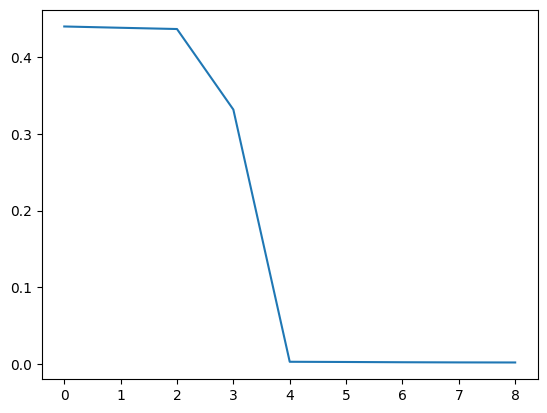

In [ ]:
# %%

# mean of samples of alpha
alpha_samples = bpca.trace.posterior['alpha'].values
alpha_samples_mean = alpha_samples.mean(axis=(0,1))
plt.plot(sorted(alpha_samples_mean**(-1), reverse=True))

In [ ]:
# %%

%%timeit -n 1 -r 3
bpca.fit(
    iterations=1,
    tune=0,
    method='nuts',
    # method = 'metropolis'
    )

Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace inst

Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use p

Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc

Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.


6.47 s ± 76.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
# %%

%%timeit -n 1 -r 3
bpca.fit(
    iterations=101,
    tune=0,
    method='nuts',
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/n

Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 10 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pym

Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 7 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc

Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 10 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


15.2 s ± 1.63 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
# %%

'''
time each sampling method
'''
# method = 'nuts'
method = 'metropolis'
# method = 'hmc'
# method = 'smc'
print(f'method = {method}')

method = metropolis


In [ ]:
# %%

%%timeit -n 1 -r 3
bpca.fit(
    iterations=1,
    tune=0,
    method=method,
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Us

Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sc

Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sc

Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.


3.51 s ± 43.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
# %%

%%timeit -n 1 -r 3
bpca.fit(
    iterations=101,
    tune=0,
    method=method,
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Us

Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  

Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  

Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


27.9 s ± 25.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
# %%

'''
time each sampling method
'''
# method = 'nuts'
# method = 'metropolis'
method = 'hmc'
# method = 'smc'
print(f'method = {method}')

method = hmc


In [ ]:
# %%

%%timeit -n 1 -r 3
bpca.fit(
    iterations=1,
    tune=0,
    method=method,
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [mu, tau, alpha, W, x]


Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [mu, tau, alpha, W, x]


Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Only 1 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [mu, tau, alpha, W, x]


Output()

Sampling 1 chain for 0 tune and 1 draw iterations (0 + 1 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.


3.12 s ± 27.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
# %%

%%timeit -n 1 -r 3
bpca.fit(
    iterations=101,
    tune=0,
    method=method,
    )

/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [mu, tau, alpha, W, x]


Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 4 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [mu, tau, alpha, W, x]


Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 3 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
/home/sci/wztao/miniconda3/envs/pymc_/lib/python3.11/site-packages/pytensor/tensor/nlinalg.py:182: FutureWarning: pytensor.tensor.linalg.trace is deprecated. Use pytensor.tensor.trace instead.
  warnings.warn(
Sequential sampling (1 chains in 1 job)
HamiltonianMC: [mu, tau, alpha, W, x]


Output()

Sampling 1 chain for 0 tune and 101 draw iterations (0 + 101 draws total) took 4 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


6.57 s ± 76.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
